# Combined kernel with kxx, kxf, kff as methods

In [1]:
import numpy as np
import gpjax as gpx
import os
import jax
import matplotlib.pyplot as plt
import jax.random as jr

from dataclasses import dataclass, field

from beartype.typing import Union
import jax.numpy as jnp
from jaxtyping import Float
import tensorflow_probability.substrates.jax.bijectors as tfb
import tensorflow_probability.substrates.jax.distributions as tfd

from gpjax.base import param_field, static_field
from gpjax.kernels.base import AbstractKernel
from gpjax.kernels.stationary.utils import squared_distance
from gpjax.typing import (
    Array,
    ScalarFloat,
)

from beartype.typing import Callable
from jaxtyping import Int

from p53_data import JAXP53_Data, dataset_3d, generate_test_times
jax.config.update('jax_enable_x64', True)

from matplotlib import rcParams

plt.style.use("https://raw.githubusercontent.com/JaxGaussianProcesses/GPJax/main/docs/examples/gpjax.mplstyle")

# Check if LaTeX is in notebook path
if os.environ.get('PATH') is not None:
    if 'TeX' not in os.environ['PATH']:
        os.environ['PATH'] += os.pathsep + '/Library/TeX/texbin'

colors = rcParams["axes.prop_cycle"].by_key()["color"]

import tensorflow_probability.substrates.jax.bijectors as tfb

key = jr.PRNGKey(42)

/opt/anaconda3/envs/gpjax_wp289/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/anaconda3/envs/gpjax_wp289/lib/python3.10/site-packages/cola/backends/backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


In [2]:
p53_data = JAXP53_Data(replicate=0)
training_times, gene_expressions, variances = dataset_3d(p53_data)

### Combined kernel

In [3]:
@dataclass
class latent_kernel(gpx.kernels.AbstractKernel):
    r"Combined covariance for learning the latent replication of p53"

    name: str = "p53 Cov"

    # Define parameters
    # BUG: crashes when using unconstrained parameters

    # Sensitivities of the genes
    initial_sensitivities = jnp.array([1.0, 1.0, 1.0, 1.0, 1.0], dtype=jnp.float64)
    #initial_unconstrained_s = tfb.Softplus().inverse(initial_constrained_s)

    true_s: Float[Array, "1 5"] = param_field(
        initial_sensitivities,
        bijector=tfb.Softplus(),
        metadata={"name": " kxx_sensitivities"},
        trainable=True,
    )

    # Degradation rates of the genes
    initial_decays = jnp.array([0.4, 0.4, 0.4, 0.4, 0.4], dtype=jnp.float64)
    #initial_unconstrained_d = tfb.Softplus().inverse(initial_constrained_d)

    true_d: Float[Array, "1 5"] = param_field(
        initial_decays,
        bijector=tfb.Softplus(),
        metadata={"name": " kxx_degradations"},
        trainable=True,
    )

    # Sigmoid to map real numbers to (0,1) and then scales and shifts to get(0.5, 3.5) # NOTE: tfb.Chain acts Right to Left
    l_bijector = tfb.Chain(
        [
            tfb.Shift(jnp.array(0.5, dtype=jnp.float64)),
            tfb.Scale(jnp.array(3.0, dtype=jnp.float64)),
            tfb.Sigmoid(),
        ]
    )

    initial_lengthscale = jnp.array(2.5, dtype=jnp.float64)
    #initial_unconstrained_l = l_bijector.inverse(initial_lengthscale)

    l: Float[Array, " O"] = param_field(
        initial_lengthscale, bijector=l_bijector, metadata={"name": "lengthscale"}
    )

    # Redefine parameters as static fields
    #true_s: Float[Array, "1 5"] = static_field(jnp.array([1.0,1.0,1.0,1.0,1.0]))
    #true_d: Float[Array, "1 5"] = static_field(jnp.array([0.4,0.4,0.4,0.4,0.4]))
    #l: Float[Array, " O"] = static_field(jnp.array(2.5))

    def __call__(self, t: Float[Array, "1 3"], t_prime: Float[Array, "1 3"]) -> ScalarFloat:
        
        # Get flag from input (1 = gene expression, 0 = latent force function)
        f1 = jnp.array(t[2], dtype=int)
        f2 = jnp.array(t_prime[2], dtype=int)

        # Cannot use if statements in kernels -> use switches
        kxx_switch = f1 * f2
        kff_switch = (1 - f1) * (1 - f2)
        kxf_switch = f1 * (1 - f2)
        kxf_t_switch = (1 - f1) * f2

        final_kernel = (
            kxx_switch * self.kernel_xx(t, t_prime)
            + kff_switch * self.kernel_ff(t, t_prime)
            + kxf_switch * self.kernel_xf(t, t_prime)
            + kxf_t_switch * self.kernel_xf(t_prime, t)
        )

        return final_kernel

    def kernel_xx(
        self, t: Float[Array, "1 3"], t_prime: Float[Array, "1 3"]
    ) -> ScalarFloat:
        """
        Equation 5 in paper k_xx(t,t')
        
        print('Input to kxx')
        print(f"t: {t}")
        print(f"t_prime: {t_prime}")
        """

        # Error trap (JAX friendly)
        def check_validity(condition):
            if condition:
                # raise ValueError("t or t' cannot be testing points (z=0)")
                return 0

        condition = jnp.logical_or(t[2] == 0, t_prime[2] == 0)
        jax.debug.callback(check_validity, condition)

        # Get gene indices
        j = t[1].astype(int)
        k = t_prime[1].astype(int)

        t = t[0]
        t_prime = t_prime[0]

        # Equation 5
        mult = self.true_s[j] * self.true_s[k] * self.l * jnp.sqrt(jnp.pi) * 0.5
        second_term = self.h(k, j, t_prime, t) + self.h(j, k, t, t_prime)

        kxx = mult * second_term
        
        return kxx.squeeze()

    def kernel_xf(
        self, t: Float[Array, "1 3"], t_prime: Float[Array, "1 3"]
    ) -> ScalarFloat:
        # Get gene expression and latent force from flag (kxf anf kfx are transposes)
        gene_xpr = jnp.where(t[2] == 0, t_prime, t)
        latent_force = jnp.where(t[2] == 0, t, t_prime)

        j = gene_xpr[1].astype(int)

        # Slice inputs
        gene_xpr = gene_xpr[0]
        latent_force = latent_force[0]

        t_dist = jnp.abs(gene_xpr - latent_force)

        first_term = 0.5 * self.l * jnp.sqrt(jnp.pi) * self.true_s[j]
        first_expon_term = jnp.exp(self.gamma(j) ** 2)
        second_expon_term = jnp.exp(-self.true_d[j] * t_dist)
        erf_terms = jax.scipy.special.erf(
            (t_dist / self.l) - self.gamma(j)
        ) + jax.scipy.special.erf(latent_force / self.l + self.gamma(j))

        kxf = first_term * first_expon_term * second_expon_term * erf_terms
        return kxf.squeeze()

    def kernel_ff(
        self, t: Float[Array, "1 3"], t_prime: Float[Array, "1 3"]
    ) -> ScalarFloat:

        t = t[0] / self.l
        t_prime = t_prime[0] / self.l

        K = jnp.exp(-0.5 * squared_distance(t, t_prime))

        return K.squeeze()

    # Helper functions
    def h(
        self,
        j: Int[Array, " O"],
        k: Int[Array, " O"],
        t1: Float[Array, " O"],
        t2: Float[Array, " O"],
    ) -> ScalarFloat:
        """
        Analytical solution for the convolution of the exponential kernel with a step function.
        """

        # Debug print
        """
        print(f"j: {j}")
        print(f"k: {k}")
        print(f"t1: {t1}")
        print(f"t2: {t2}")
        """
        t_dist = t2 - t1

        multiplier = jnp.exp(self.gamma(k) ** 2) / (self.true_d[j] + self.true_d[k])

        first_multiplier = jnp.exp(-self.true_d[k] * t_dist)
        first_erf_terms = jax.scipy.special.erf(
            (t_dist / self.l) - self.gamma(k)
        ) + jax.scipy.special.erf(t1 / self.l + self.gamma(k))

        second_multiplier = jnp.exp(-(self.true_d[k] * t2 + self.true_d[j] * t1))
        second_erf_terms = jax.scipy.special.erf(
            (t2 / self.l) - self.gamma(k)
        ) + jax.scipy.special.erf(self.gamma(k))

        result = multiplier * (
            jnp.multiply(first_multiplier, first_erf_terms)
            - jnp.multiply(second_multiplier, second_erf_terms)
        )

        #print(f"result: {result}")
        return result

    def gamma(self, k: Int[Array, " O"]) -> ScalarFloat:
        # Gamma term for h function
        return (self.true_d[k] * self.l) / 2


### Custom mean function

The mean function for the gene expressions per time is used to obtain the basal rates:

$$
f(x_{j}) = \frac{B_{j}}{D_{j}} 
$$

In [4]:
# Define custom mean
@dataclass
class latent_mean(gpx.mean_functions.AbstractMeanFunction):
    r"""
    Simple Input Motif mean function

    ```math
        f(x_{j}) = \frac{B_{j}}{D_{j}} 
    ```

    From equation 2 in paper.

    $B_{j}$ represents the basal rate for gene $j$ and is a trainable paramater.
    """

    # Pass kernel instance that contains true_d parameter
    kernel: gpx.kernels.AbstractKernel = field(default_factory=lambda: latent_kernel())
    
    #true_d: Float[Array, "1 5"] = static_field(jnp.array([0.05, 0.05, 0.05, 0.05, 0.05], dtype=jnp.float64))
    
    # Define parameters
    initial_constrained_b = jnp.array([0.05, 0.05, 0.05, 0.05, 0.05], dtype=jnp.float64)
    
    true_b: Float[Array, "1 5"] = param_field(initial_constrained_b, bijector=tfb.Softplus(), metadata={"name": " basal_rates"}, trainable=True,)

    def __call__(self, x: Float[Array, "N D"]) -> Float[Array, "N O"]:
        r"""Evaluate the mean function at the given points.

        Args:
            x (Float[Array, " D"]): The point at which to evaluate the mean function.

        Returns
        -------
            Float[Array, "1"]: The evaluated mean function.
        """
        # BUG: Concretization error if this is used ?
        #num_genes = len(jnp.unique(x[:, 1]))
        num_genes = 5

        decays = self.kernel.true_d
        
        block_size = (x.shape[0] // num_genes)
        # Define the mean function
        #mean = (self.true_b / self.true_d).reshape(1, -1)
        mean = (self.true_b / decays).reshape(1, -1)
        mean = mean.repeat(block_size, jnp.newaxis).reshape(-1,1)

        return mean

## GP regression

In [5]:
dataset_train = gpx.Dataset(training_times, gene_expressions)

testing_times = generate_test_times()

In [6]:
def initialise_gp(kernel, mean, dataset):
    prior = gpx.gps.Prior(mean_function=mean, kernel=kernel)
    likelihood = gpx.likelihoods.Gaussian(
        num_datapoints=dataset.n, obs_stddev=jnp.array([1.0e-3], dtype=jnp.float64)
    )
    posterior = prior * likelihood
    return posterior

#meanf = gpx.mean_functions.Zero()
meanf = latent_mean()
p53_ker = latent_kernel()

posterior = initialise_gp(p53_ker, meanf, dataset_train)

In [ ]:
#p53_ker.kernel_xx(training_times, training_times)

In [7]:
def optimise_mll(posterior, dataset, NIters=1000, key=key):
    # define the MLL using dataset_train
    objective = gpx.objectives.ConjugateMLL(negative=True)
    print(f'MLL before opt: {objective(posterior, dataset):.3f}')
    # Optimise to minimise the MLL
    opt_posterior, history = gpx.fit_scipy(
        model=posterior,
        objective=objective,
        train_data=dataset,
    )
    return opt_posterior, history

In [8]:
import optax as ox
#jax.config.update("jax_debug_nans", True)

def optimise_mll2(posterior, dataset, NIters=1000, key=key):
    # define the MLL using dataset_train
    objective = gpx.objectives.ConjugateMLL(negative=True)
    print(f'MLL before opt: {objective(posterior, dataset):.3f}')
    # Optimise to minimise the MLL
    opt_posterior, history = gpx.fit(
        model=posterior,
        objective=objective,
        train_data=dataset, 
        optim=ox.adam(1e-1), 
        num_iters=NIters,
        key=key,
        safe=False)
    return opt_posterior, history

In [9]:
opt_posterior, history = optimise_mll2(posterior, dataset_train)

/opt/anaconda3/envs/gpjax_wp289/lib/python3.10/site-packages/cola/backends/backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)
/opt/anaconda3/envs/gpjax_wp289/lib/python3.10/site-packages/cola/backends/backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


MLL before opt: 1740886.393


Running: 100%|██████████| 1000/1000 [01:06<00:00, 14.93it/s, Value=276.49]  


In [ ]:
# Plot history of MLL
plt.plot(history)
plt.xlabel("Iteration")
plt.ylabel("MLL")
plt.show()

In [10]:
def plot_gp(x_test, predictive_dist):
    """
    Plot LF GP given test points and prediction

    Parameters
    ----------
    x_test: array of shape (n, 3)
    predictive_dist:  jax mvn
    """

    predictive_mean = predictive_dist.mean()
    predictive_std = predictive_dist.variance()

    # (100,)
    x_test = x_test[:,0]

    import matplotlib as mpl
    cols = mpl.rcParams["axes.prop_cycle"].by_key()["color"]
    fig, ax = plt.subplots(figsize=(7.5, 2.5))

    ax.fill_between(
        x_test.squeeze(),
        predictive_mean - 2 * predictive_std,
        predictive_mean + 2 * predictive_std,
        alpha=0.2,
        label="Two sigma",
        color=cols[1],
    )
    ax.plot(
        x_test,
        predictive_mean - 2 * predictive_std,
        linestyle="--",
        linewidth=1,
        color=cols[1],
    )
    ax.plot(
        x_test,
        predictive_mean + 2 * predictive_std,
        linestyle="--",
        linewidth=1,
        color=cols[1],
    )
    
    ax.plot(x_test, predictive_mean, label="Predictive mean", color=cols[1])
    ax.legend(loc="center left", bbox_to_anchor=(0.975, 0.5))
    ax.set_xlabel("Time")
    ax.set_ylabel("mRNA Expression")

In [11]:
latent_dist = opt_posterior.predict(testing_times, train_data=dataset_train)

/opt/anaconda3/envs/gpjax_wp289/lib/python3.10/site-packages/cola/backends/backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


In [15]:
latent_dist.stddev()

/opt/anaconda3/envs/gpjax_wp289/lib/python3.10/site-packages/cola/backends/backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


Array([0.71728409,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        

In [12]:
predictive_dist = opt_posterior.likelihood(latent_dist)

In [13]:
predictive_dist.stddev()

Array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan], dtype=float64)

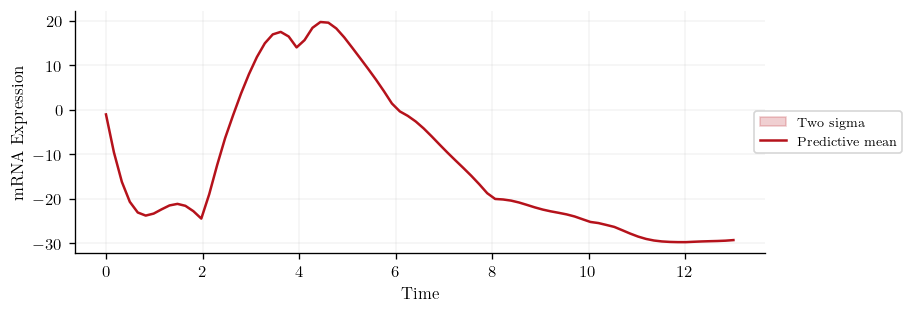

In [14]:
plot_gp(testing_times, predictive_dist)

In [16]:
from gpjax.base import meta_leaves

leaves = meta_leaves(opt_posterior)
print(len(leaves))
leaves

8


[({'bijector': <tfp.bijectors.Softplus 'softplus' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>,
   'trainable': True,
   'pytree_node': True},
  Array([0.03599095], dtype=float64)),
 ({'name': 'lengthscale',
   'bijector': <tfp.bijectors.Chain 'chain_of_shift_of_scale_of_sigmoid' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=float64 dtype_y=float64 bijectors=[<tfp.bijectors.Shift 'shift' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=float64 dtype_y=float64>, <tfp.bijectors.Scale 'scale' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=float64 dtype_y=float64>, <tfp.bijectors.Sigmoid 'sigmoid' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>]>,
   'trainable': True,
   'pytree_node': True},
  Array(0.74079216, dtype=float64)),
 ({'name': ' kxx_degradations',
   'bijector': <tfp.bijectors.Softplus 'softplus' batch_shape=[] f

## Debugging NaNs

In [17]:
def generate_test_times(t=100):
    """
    Generate testing times for the GP model to predict the latent force function.

    Parameters
    ----------
    t : int, optional
        Number of testing times. Default is 80.

    Returns
    -------
    testing_times : jnp.ndarray
        Array of testing times of shape (t, 3) where t is the number of testing times.
    """

    times = jnp.linspace(0, 13, t)
    # Gene indices shouldn't matter
    gene_indices = jnp.repeat(-1, t)
    testing_times = jnp.stack((times, gene_indices, jnp.repeat(0, t)), axis=-1)
    return testing_times

In [18]:
test_times_2 = generate_test_times(t=80)
print(test_times_2.shape)

(80, 3)


In [19]:
test_X = dataset_train.X

testing_mean = jax.vmap(lambda x: opt_posterior.predict(x, dataset_train).mean(),1)(test_times_2[:,None,:]).squeeze()

testing_mean.shape

(80,)

In [24]:
jax.vmap(lambda x: opt_posterior.predict(x, dataset_train).stddev(),1)(test_X[:,None,:]).squeeze()

Array([0.001     , 0.01893627, 0.01895798, 0.01896913, 0.01897498,
       0.01898034, 0.01899368, 0.001     , 0.01704163, 0.01711155,
       0.01713929, 0.01715031, 0.01715484, 0.01715723, 0.001     ,
       0.01828349, 0.01828717, 0.01829016, 0.01829207, 0.01829484,
       0.01830337, 0.001     , 0.0349659 , 0.0348233 , 0.0348195 ,
       0.03482388, 0.03483475, 0.03493618, 0.001     , 0.01807493,
       0.01807434, 0.01807533, 0.01807608, 0.01807729, 0.01808072],      dtype=float64)

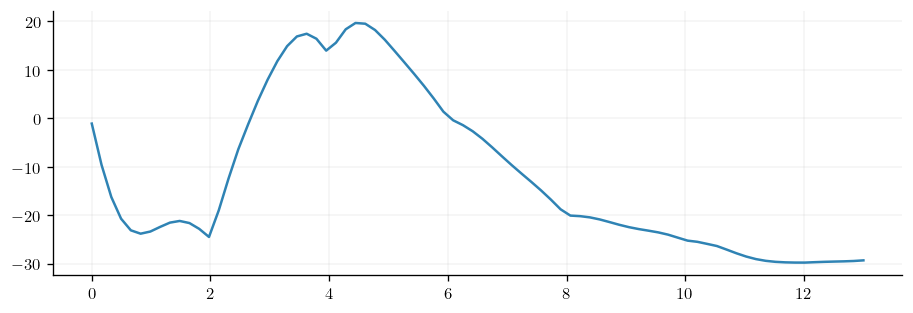

In [21]:
# Plot testing_mean and testing_variance

testing_mean = jax.vmap(lambda x: opt_posterior.predict(x, dataset_train).mean(),1)(testing_times[:,None,:]).squeeze()

testing_stddev = jax.vmap(lambda x: opt_posterior.predict(x, dataset_train).stddev(),1)(testing_times[:,None,:]).squeeze()

fig, ax = plt.subplots(figsize=(7.5, 2.5))

ax.fill_between(testing_times[:,0], testing_mean - testing_stddev, testing_mean + testing_stddev, alpha=0.2,label='1 Posteriod s.d')

ax.plot(testing_times[:,0], testing_mean, label='Predictive mean')

plt.show()

In [22]:
testing_stddev

Array([0.71728409,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        

In [25]:
vars_t = jax.vmap(lambda x: opt_posterior.predict(x, dataset_train).variance(),1)(testing_times[:,None,:]).squeeze()

In [ ]:
vars_t * -1

In [ ]:
debug_x = dataset_train.X


In [26]:
cov_matrix = latent_dist.covariance()
assert np.allclose(cov_matrix, cov_matrix.T), "Covariance matrix is not symmetric"
eigenvalues = np.linalg.eigvalsh(cov_matrix)
if np.any(eigenvalues <= 0):
    print("Covariance matrix is not positive definite")

Covariance matrix is not positive definite


In [27]:
gram_array = opt_posterior.prior.kernel.gram(dataset_train.X).to_dense()

In [28]:
opt_posterior.prior.kernel

latent_kernel(compute_engine=DenseKernelComputation(), active_dims=None, name='p53 Cov', true_s=Array([1.36255   , 1.30710909, 1.33513753, 0.90555277, 1.35073238],      dtype=float64), true_d=Array([0.18866351, 0.21973712, 0.19360095, 0.87383398, 0.20278081],      dtype=float64), l=Array(0.74079216, dtype=float64))

# Debugging kernels I/O

In [ ]:
import cola

@dataclass
class latent_kernel_test(gpx.kernels.AbstractKernel):
    r"Combined covariance for learning the latent replication of p53"

    name: str = "p53 Cov Test"
    initial_sensitivities = jnp.array([1.0, 1.0, 1.0, 1.0, 1.0], dtype=jnp.float64)


    true_s: Float[Array, "1 5"] = param_field(
        initial_sensitivities,
        bijector=tfb.Softplus(),
        metadata={"name": " kxx_sensitivities"},
        trainable=True,
    )


    initial_decays = jnp.array([0.4, 0.4, 0.4, 0.4, 0.4], dtype=jnp.float64)


    true_d: Float[Array, "1 5"] = param_field(
        initial_decays,
        bijector=tfb.Softplus(),
        metadata={"name": " kxx_degradations"},
        trainable=True,
    )

    # Sigmoid to map real numbers to (0,1) and then scales and shifts to get(0.5, 3.5) # NOTE: tfb.Chain acts Right to Left
    l_bijector = tfb.Chain(
        [
            tfb.Shift(jnp.array(0.5, dtype=jnp.float64)),
            tfb.Scale(jnp.array(3.0, dtype=jnp.float64)),
            tfb.Sigmoid(),
        ]
    )

    initial_lengthscale = jnp.array(2.5, dtype=jnp.float64)

    l: Float[Array, " O"] = param_field(
        initial_lengthscale, bijector=l_bijector, metadata={"name": "lengthscale"}
    )

    def __call__(self, t: Float[Array, "1 3"], t_prime: Float[Array, "1 3"]) -> ScalarFloat:
        
        # Get flag from input (1 = gene expression, 0 = latent force function)
        f1 = jnp.array(t[2], dtype=int)
        f2 = jnp.array(t_prime[2], dtype=int)

        # Cannot use if statements in kernels -> use switches
        kxx_switch = f1 * f2
        kff_switch = (1 - f1) * (1 - f2)
        kxf_switch = f1 * (1 - f2)
        kxf_t_switch = (1 - f1) * f2

        final_kernel = (
            kxx_switch * self.kernel_xx(t, t_prime)
            + kff_switch * self.kernel_ff(t, t_prime)
            + kxf_switch * self.kernel_xf(t, t_prime)
            + kxf_t_switch * self.kernel_xf(t_prime, t)
        )

        return final_kernel

    def kernel_xx(
        self, t: Float[Array, "1 3"], t_prime: Float[Array, "1 3"]
    ) -> ScalarFloat:
        """
        Equation 5 in paper k_xx(t,t')
        
        print('Input to kxx')
        print(f"t: {t}")
        print(f"t_prime: {t_prime}")
        """

        # Get gene indices
        j = t[1].astype(int)
        k = t_prime[1].astype(int)

        t = t[0]
        t_prime = t_prime[0]

        # Equation 5
        mult = self.true_s[j] * self.true_s[k] * self.l * jnp.sqrt(jnp.pi) * 0.5
        second_term = self.h(k, j, t_prime, t) + self.h(j, k, t, t_prime)

        kxx = mult * second_term
        
        return kxx.squeeze()
    
    def h(
        self,
        j: Int[Array, " O"],
        k: Int[Array, " O"],
        t1: Float[Array, " O"],
        t2: Float[Array, " O"],
    ) -> ScalarFloat:
        """
        Analytical solution for the convolution of the exponential kernel with a step function.
        """

        # Debug print
        """
        print(f"j: {j}")
        print(f"k: {k}")
        print(f"t1: {t1}")
        print(f"t2: {t2}")
        """
        t_dist = t2 - t1

        multiplier = jnp.exp(self.gamma(k) ** 2) / (self.true_d[j] + self.true_d[k])

        first_multiplier = jnp.exp(-self.true_d[k] * t_dist)
        first_erf_terms = jax.scipy.special.erf(
            (t_dist / self.l) - self.gamma(k)
        ) + jax.scipy.special.erf(t1 / self.l + self.gamma(k))

        second_multiplier = jnp.exp(-(self.true_d[k] * t2 + self.true_d[j] * t1))
        second_erf_terms = jax.scipy.special.erf(
            (t2 / self.l) - self.gamma(k)
        ) + jax.scipy.special.erf(self.gamma(k))

        result = multiplier * (
            jnp.multiply(first_multiplier, first_erf_terms)
            - jnp.multiply(second_multiplier, second_erf_terms)
        )

        #print(f"result: {result}")
        return result

    def kernel_xf(
        self, t: Float[Array, "1 3"], t_prime: Float[Array, "1 3"]
    ) -> ScalarFloat:
        # Get gene expression and latent force from flag (kxf anf kfx are transposes)
        gene_xpr = jnp.where(t[2] == 0, t_prime, t)
        latent_force = jnp.where(t[2] == 0, t, t_prime)

        j = gene_xpr[1].astype(int)

        # Slice inputs
        gene_xpr = gene_xpr[0]
        latent_force = latent_force[0]

        t_dist = jnp.abs(gene_xpr - latent_force)

        first_term = 0.5 * self.l * jnp.sqrt(jnp.pi) * self.true_s[j]
        first_expon_term = jnp.exp(self.gamma(j) ** 2)
        second_expon_term = jnp.exp(-self.true_d[j] * t_dist)
        erf_terms = jax.scipy.special.erf(
            (t_dist / self.l) - self.gamma(j)
        ) + jax.scipy.special.erf(latent_force / self.l + self.gamma(j))

        kxf = first_term * first_expon_term * second_expon_term * erf_terms
        return kxf.squeeze()

    def kernel_ff(
        self, t: Float[Array, "1 3"], t_prime: Float[Array, "1 3"]
    ) -> ScalarFloat:

        t = t[0] / self.l
        t_prime = t_prime[0] / self.l

        K = jnp.exp(-0.5 * squared_distance(t, t_prime))

        return K.squeeze()

    # Helper functions

    def gamma(self, k: Int[Array, " O"]) -> ScalarFloat:
        # Gamma term for h function
        return (self.true_d[k] * self.l) / 2


In [ ]:
t_ker = latent_kernel_test()

t_ker.kernel_xx(training_times[15], training_times[15])

In [ ]:
# Rebuild Kxx matrix
test_times_pt = jnp.array([ 0.,  2.,  4.,  6.,  8., 10., 12.,  0.,  2.,  4.,  6.,  8., 10., 12., 0.,  2.,  4.,  6.,  8., 10., 12.,  0.,  2.,  4.,  6.,  8., 10., 12., 0.,  2.,  4.,  6.,  8., 10., 12.], dtype=jnp.float64)


def forward(t1, t2):
    """
    This calculates Kxx (not cross-covariance)
    t1, t2 are blocked timepoint vectors
    Parameters:
        x1 shape (num_genes*num_times)
    """
    num_genes = 5

    vert_block_size = int(t1.shape[0] / num_genes) # 7
    hori_block_size = int(t2.shape[0] / num_genes) # 7
    t1_block, t2_block = t1[:vert_block_size], t2[:hori_block_size]
    shape = [vert_block_size * num_genes, hori_block_size * num_genes]
    K_xx = jnp.zeros(shape, dtype=jnp.float64)

    for j in range(num_genes):
        for k in range(num_genes):
            # make fake arrays
            print(t1_block.shape)
            print(t1_block)
            ar_1 = jnp.array([t1_block, j, 1])
            ar_2 = jnp.array([t2_block, k, 1])

            kxx = t_ker.kernel_xx(ar_1, ar_2)


            #kxx = self.k_xx(j, k, t1_block, t2_block)
            K_xx[j * vert_block_size:(j + 1) * vert_block_size,
                    k * hori_block_size:(k + 1) * hori_block_size] = kxx
    return K_xx


In [ ]:
output_test = t_ker.gram(training_times)

In [ ]:
output_test.to_dense()

In [ ]:
import pandas as pd
res = np.array(output_test.to_dense())
pd.DataFrame(res)

In [ ]:
res.shape

In [ ]:
kxx_test = output_test
kxx_test += cola.ops.I_like(kxx_test) * 1e-4
kxx_test_psd = cola.PSD(kxx_test)
kxx_test = np.array(kxx_test_psd.to_dense())

In [ ]:
pd.DataFrame(kxx_test)

In [ ]:
# Add noise to res
jit = 1e-4 * np.eye(res.shape[0])
res_noisy = res + jit

pd.DataFrame(res_noisy)

In [ ]:
np.linalg.det(res_noisy)

In [ ]:
# load k_XX_torch.npy
k_XX_torch = np.load('k_XX_torch.npy')

In [ ]:
np.array_equal(kxx_test, k_XX_torch)

In [ ]:
np.allclose(kxx_test, k_XX_torch)

In [ ]:
np.linalg.det(res_noisy)

In [ ]:
np.linalg.inv(res_noisy)

In [ ]:
## Adding jitter seems to fix the issue

# Run GP regression, checking matrices at every step

mean_func_testing = gpx.mean_functions.Zero()
prior_testing = gpx.gps.Prior(mean_function=mean_func_testing, kernel=t_ker, jitter=1e-4)

In [ ]:
likelihood_testing = gpx.likelihoods.Gaussian(num_datapoints=dataset_train.n)

In [ ]:
likelihood_testing.obs_stddev

In [ ]:
posterior_testing = prior_testing * likelihood_testing

In [ ]:
optimised_posterior, history = optimise_mll(posterior_testing, dataset_train)

In [ ]:
latent_testing = optimised_posterior.predict(testing_times, train_data=dataset_train)
predictive_dist_testing = optimised_posterior.likelihood(latent_testing)

In [ ]:
latent_testing.stddev()

In [ ]:
meta_leaves(optimised_posterior)

In [ ]:
import cola.ops


def post_predict(test_inputs, train_data):
        
        x, y = train_data.X, train_data.y

        # Unpack test inputs
        t = test_inputs

        # Observation noise o²
        likelihood_obs_stddev = jnp.array(1.0)
        obs_noise = likelihood_obs_stddev**2
        mx = prior_testing.mean_function(x)

        # Precompute Gram matrix, Kxx, at training inputs, x
        Kxx = prior_testing.kernel.gram(x)
        Kxx += cola.ops.I_like(Kxx) * prior_testing.jitter

        # Σ = Kxx + Io²
        Sigma = Kxx + cola.ops.I_like(Kxx) * obs_noise
        Sigma = cola.PSD(Sigma)

        mean_t = prior_testing.mean_function(t)
        
        Ktt = prior_testing.kernel.gram(t)
        Kxt = prior_testing.kernel.cross_covariance(x, t)
        
        Sigma_inv_Kxt = cola.solve(Sigma, Kxt)

        # μt  +  Ktx (Kxx + Io²)⁻¹ (y  -  μx)
        mean = mean_t + jnp.matmul(Sigma_inv_Kxt.T, y - mx)

        # Ktt  -  Ktx (Kxx + Io²)⁻¹ Kxt
        
        covariance = Ktt - jnp.matmul(Kxt.T, Sigma_inv_Kxt)
        print(covariance.to_dense().shape)
        covariance += cola.ops.I_like(covariance) * prior_testing.jitter
        covariance = cola.PSD(covariance)

        # Check PSD of final covariance matrix
        def is_pos_def(x):
              return jnp.all(jnp.linalg.eigvals(x) > 0)
        if not is_pos_def(covariance.to_dense()):
            print("Covariance matrix is not positive definite")

        
        # Diagonalise covariance matrix
        diag_cov = jnp.diag(jnp.diag(covariance.to_dense()))
        #diag_cov += prior_testing.jitter * jnp.eye(diag_cov.shape[-1])
        diag_cov += cola.ops.I_like(diag_cov) * prior_testing.jitter

        # Convert diag_cov to Cola LinearOperator
        diag_cov = cola.PSD(diag_cov)

        print(type(covariance))
        print(type(diag_cov))

        return mean.squeeze(), covariance, GaussianDistribution(jnp.atleast_1d(mean.squeeze()), diag_cov)

mean_func, cov_matrix, latent_test_dist = post_predict(testing_times, dataset_train)
stddev = latent_test_dist.stddev()

In [ ]:
stddev

In [ ]:
var = cov_matrix.to_dense()
var = jnp.diag(jnp.diag(var))
var += prior_testing.jitter * jnp.eye(var.shape[-1])

# Check that var is PSD
def is_pos_def(x):
      return jnp.all(jnp.linalg.eigvals(x) > 0)

var

In [ ]:
jnp.diag(cov_matrix.to_dense())

In [ ]:
import torch
cov_matrix_torch = torch.tensor(np.asarray(cov_matrix.to_dense()))
print(f'Cov mat shape: {cov_matrix_torch.shape}')
cov_matrix_torch = cov_matrix_torch.unsqueeze(0)
print(f'Cov mat shape: {cov_matrix_torch.shape}')
cov_matrix_torch = torch.diagonal(cov_matrix_torch, dim1=1, dim2=2)
print(f'Cov mat shape: {cov_matrix_torch.shape}')
cov_matrix_torch = torch.diag_embed(cov_matrix_torch)
print(f'Cov mat shape: {cov_matrix_torch.shape}')
cov_matrix_torch

In [ ]:
diag1 = cola.ops.Diagonal(cov_matrix.to_dense())
diag2 = cola.ops.Diagonal(diag1.to_dense())
diag2 = cola.PSD(diag2)
diag2.to_dense()

In [ ]:
cov_matrix.to_dense()

In [ ]:
cola.diag(cov_matrix)

In [ ]:
latent_test_dist.variance()

In [ ]:
latent_test_dist.covariance()

In [ ]:
import gpytorch
import torch

mean_func_torch = torch.from_numpy(np.array(mean_func))
cov_matrix_torch = torch.from_numpy(np.array(cov_matrix))

batch_mvn = gpytorch.distributions.MultivariateNormal(mean_func, cov_matrix)

In [ ]:
# Load torch dist
torch_cov = np.load('p_f_cov.npy')

In [ ]:
from gpjax.distributions import GaussianDistribution


In [ ]:
latent_test_dist = post_predict(testing_times, dataset_train)

In [ ]:
latent_test_dist.stddev()

In [ ]:
np.isnan(latent_test_dist.stddev()).any()